# Assignment 6

This assignment has weighting $3.5$.
The first question about clustering has 35%, and the second question about tiny image classification has 65%.

This is a challenging assignment, so I recommend you start early.

### Huang Kai     UID: 3035086340

# Clustering for handwritten digits

Supervised learning requires labeled data, which can be expensive to acquire.
For example, a dataset with $N$ samples for classification will require manual labeling $N$ times.

One way to ameliorate this issue is to perform clustering of the raw data samples first, followed by manual inspection and labeling of only a few samples.
Recall that clustering is a form of non-supervised learning, so it does not require any class labels.

For example, say we are given a set of scanned hand-written digit images.
We can cluster them into 10 groups first, manually inspect and label a few images in each cluster, and propagate the label towards the rest of all (unlabeled) samples in each cluster.

The accuracy of such semi-automatic labeling depends on the accuracy of the clustering.
If each cluster (0 to 9) corresponds exactly to hand-written digits 0-9, we are fine.
Otherwise, we have some mis-labeled data.

The goal of this question is to exercise clustering of the scikit-learn digits dataset which has labels, so that we can verify our clustering accuracy.
The specifics are as follows.

You will be judged by the test accuracy of your code, and quality of descriptions of your method.
As a reference, a simple code I (Li-Yi) wrote can achieve about 78% accuracy. Try to beat it as much as you can.

## Training and test data split

We will split the original dataset into training and test datasets
* training for building our clusters
* testing to see if the clusters can predict future data

## Accuracy
What is your clustering accuracy (comparing cluster labels with the ground truth labels), and what are the properties of mis-clustered samples?

## Data preprocessing
Would the original features (pixels) work well, or we need further processing like scaling/standardization or dimensionality-reduction, before clustering?

## Models and hyper-parameters

Let's focus on k-means clustering, as hierarchical and density-based clustering do not provide the predict() method under scikit-learn.

What is the best test performance you can achieve with which hyper-parameters (for k-means, standard scalar, and dimensionality reduction)?

### Hint
We have learned Pipeline and GridSearchCV for cross validation and hyper-parameter tuning.

In [1]:
%load_ext watermark
%watermark -a '' -u -d -v -p numpy,pandas,matplotlib,scipy,sklearn
%matplotlib inline

last updated: 2016-12-13 

CPython 3.5.2
IPython 5.1.0

numpy 1.11.2
pandas 0.19.0
matplotlib 1.5.3
scipy 0.18.1
sklearn 0.18


In [2]:
# Added version check for recent scikit-learn 0.18 checks
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version

## Load data

In [3]:
import numpy as np

from sklearn.datasets import load_digits
digits = load_digits()

X = digits.data # data in pixels
y = digits.target # digit labels

print(X.shape)
print(y.shape)

print(np.unique(y))

(1797, 64)
(1797,)
[0 1 2 3 4 5 6 7 8 9]


## Visualize data

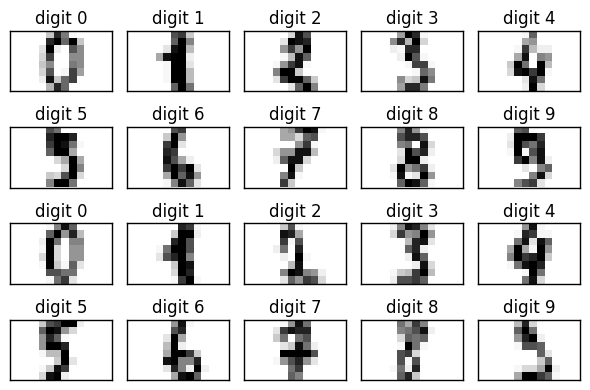

In [4]:
import matplotlib.pyplot as plt
import pylab as pl

num_rows = 4
num_cols = 5

fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, sharex=True, sharey=True)
ax = ax.flatten()
for index in range(num_rows*num_cols):
    img = digits.images[index]
    label = digits.target[index]
    ax[index].imshow(img, cmap='Greys', interpolation='nearest')
    ax[index].set_title('digit ' + str(label))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

## Data sets: training versus test

In [5]:
if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split
    
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1)

num_training = y_train.shape[0]
num_test = y_test.shape[0]
print('training: ' + str(num_training) + ', test: ' + str(num_test))

training: 1257, test: 540


In [6]:
import numpy as np

# check to see if the data are well distributed among digits
for y in [y_train, y_test]:
    print(np.bincount(y))

[119 133 128 119 120 135 130 122 128 123]
[59 49 49 64 61 47 51 57 46 57]


## Answer

We first write a scoring function for clustering so that we can use for GridSearchCV.
Take a look at make_scorer under scikit learn.

In [8]:
from sklearn.metrics import accuracy_score, make_scorer

def clustering_accuracy_score(y_true, y_pred):
    # replace this with your code; note that y_pred is just cluster id, not digit id
    
    # unique cluster ids of y_pred
    cluster_ids = np.unique(y_pred)
    # unique true labels
    labels = np.unique(y_true)
    # initialize y_cm
    y_cm = np.empty(len(y_pred), dtype=int)
    # for each cluster id
    for i in range(len(cluster_ids)):
        # find out all the true labels of those with the certain cluster id
        candidate_labels = y_true[y_pred==cluster_ids[i]]
        # count the occurrences of all candidate labels
        candidate_label_counts = np.bincount(candidate_labels)
        # get the label with the largest occurrence as the final predicted label
        label_pred = np.argmax(candidate_label_counts)
        # update the corresponding cluster id with the final predicted label
        for j in range(len(y_cm)):
            if(y_pred[j]==cluster_ids[i]):
                y_cm[j]=label_pred
    return accuracy_score(y_true=y_true, y_pred=y_cm)

clustering_accuracy = make_scorer(clustering_accuracy_score)

In [10]:
# toy case demonstrating the clustering accuracy
# this is just a reference to illustrate what this score function is trying to achieve
# feel free to design your own as long as you can justify

# ground truth class label for samples
toy_y_true = np.array([0, 0, 0, 1, 1, 2])

# clustering id for samples
toy_y_pred_true = np.array([1, 1, 1, 2, 2, 0])
toy_y_pred_bad1 = np.array([0, 0, 1, 1, 1, 2])
toy_y_pred_bad2 = np.array([2, 2, 1, 0, 0, 0])

toy_accuracy = clustering_accuracy_score(toy_y_true, toy_y_pred_true)
print('accuracy', toy_accuracy, ', should be 1')

toy_accuracy = clustering_accuracy_score(toy_y_true, toy_y_pred_bad1)
print('accuracy', toy_accuracy, ', should be', 5.0/6.0)

# toy_accuracy = clustering_accuracy_score(toy_y_true, toy_y_pred_bad2)
# print('accuracy', toy_accuracy, ', should be', 4.0/6.0)

accuracy 1.0 , should be 1
accuracy 0.833333333333 , should be 0.8333333333333334


Build a pipeline with standard scaler, PCA, and clustering.

In [11]:
# your code
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
pipe_kmeans = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=10)),
                    ('clf', KMeans(n_clusters=10, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0))])
# pipe_kmeans.fit(X_train)
# y_pred = pipe_kmeans.predict(X_test)
# print(clustering_accuracy_score(y_test,y_pred))

Use GridSearchCV to tune hyper-parameters.

In [12]:
# your code
if Version(sklearn_version) < '0.18':
    from sklearn.grid_search import GridSearchCV
else:
    from sklearn.model_selection import GridSearchCV

# tune three hyper-parameters
param_grid = {'pca__n_components': [15,20,25,30,35,40,45,50,55,60],
               'clf__n_clusters': [10,15,20,25],
               'clf__n_init': [10,20,30,40]}

gs = GridSearchCV(estimator=pipe_kmeans, 
          param_grid=param_grid, 
          scoring=clustering_accuracy, 
          cv=10, verbose=1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

Fitting 10 folds for each of 160 candidates, totalling 1600 fits


[Parallel(n_jobs=1)]: Done 1600 out of 1600 | elapsed: 12.7min finished


0.892601431981
{'clf__n_clusters': 25, 'clf__n_init': 40, 'pca__n_components': 40}


In [13]:
best_model = gs.best_estimator_ # replace this with the best model you can build

y_cm = best_model.predict(X_test)

print('Test accuracy: %.3f' % clustering_accuracy_score(y_true=y_test, y_pred=y_cm))

#print('Test accuracy: %.3f' % best_model.score(X_test, y_test))

Test accuracy: 0.881


Visualize mis-clustered samples, and provide your explanation.

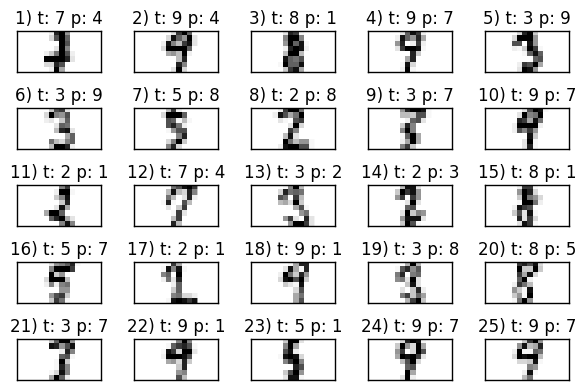

In [14]:
# Same code as in the scoring function to transform cluster ids to predicted labels
cluster_ids = np.unique(y_cm)
labels = np.unique(y_test)
y_test_pred = np.empty(len(y_cm), dtype=int)
for i in range(len(cluster_ids)):
    candidate_labels = y_test[y_cm==cluster_ids[i]]
    candidate_label_counts = np.bincount(candidate_labels)
    label_pred = np.argmax(candidate_label_counts)
    for j in range(len(y_test_pred)):
        if(y_cm[j]==cluster_ids[i]):
            y_test_pred[j]=label_pred
miscl_img = X_test[y_test != y_test_pred]
correct_lab = y_test[y_test != y_test_pred]
miscl_lab= y_test_pred[y_test != y_test_pred]

# For simplicity, just visualize 25 mis-clustered samples as an illustration
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for index in range(25):
    img = miscl_img[index].reshape(8,8)
    ax[index].imshow(img, cmap='Greys', interpolation='nearest')
    ax[index].set_title('%d) t: %d p: %d' % (index+1, correct_lab[index], miscl_lab[index]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

## Explanation
To calculate the clustering accuracy, I use the following method: For the samples in each cluster, select the most frequent corresponding true labels and treat it as the predicted digit label of all the samples in this cluster. There can be more than 10 clusters. One or more clusters can be mapped to the same digit. Even though this scoring method may not be perfect for all cases, this makes sense to some extent because the idea behind the scoring function is majority voting in one cluster. For mis-clustered samples, most likely that they differ in feature values with others (probably because one writes the digit in a slightly strange way).

For the data preprocessing part, it turns out that after doing standardization and dimensionality reduction, clustering accuracy becomes better. By using GridSearchCV, the result shows using PCA when n_components=40 combined with 25 clusters and 40 n_init has relatively good accuracy.

The best test performance I get is around 88%, which is quite good. Indeed, I only tune three hyper-parameters and there are 160 candidate combinations in total. In this case, the running time of GridSearchCV is as long as 13 minutes. In fact, better accuracy can be achieved by having more values as candidates (eg, n_components can be any integer in range(2,64); can also tune other parameters such as max_iter or tol), but surely there is a tradeoff between the computing complexity and the better accuracy.

As we can see from the figures above (I only plot 25 of them as an illustration), some of those mis-clustered samples are simply just quite vague or strange even for us human to identify correctly (for example, figure 17 and 21). Other mis-clustered samples may come from the pitfall in the accuracy scoring function when cluster ids are transformed into digit labels. Using how many clusters will also affect the performance. Cases might happen for too many clusters where in one small cluster, every sample has a different label and the scoring function will simply choose the first label, which can be a reason for mis-clustering.

# Tiny image classification

We will use the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) for image object recognition.
The dataset consists of 50000 training samples and 10000 test samples in 10 different classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck; see the link above for more information).
The goal is to maximize the accuracy of your classifier on the test dataset after being optimized via the training dataset.

You can use any learning models (supervised or unsupervised) or optimization methods (e.g. search methods for hyper-parameters).
The only requirement is that your code can run inside an ipynb file, as usual.
Please provide a description of your method, in addition to the code.
Your answer will be evaluated not only on the test accuracy but also on the creativity of your methodology and the quality of your explanation/description.

## Sample code to get you started

This is a difficult classification task.
A sample code below, based on a simple fully connected neural network built via Keras, is provided below.
The test accuracy is about 43%.

In [1]:
%load_ext watermark
%watermark -a '' -u -d -v -p numpy,keras

Using TensorFlow backend.


last updated: 2016-12-13 

CPython 3.5.2
IPython 4.2.0

numpy 1.11.1
keras 1.1.2


In [ ]:
# Sample Code
from keras.datasets import cifar10
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.constraints import maxnorm
import numpy as np
from sklearn.metrics import accuracy_score

# load data set
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

img_shape = X_train.shape[1:] # [num_rows, num_cols, num_channels]
num_img_pixels = np.prod(img_shape)
num_training_samples = X_train.shape[0]
num_test_samples = X_test.shape[0]

nb_classes = np.sum(np.unique(y_train).shape)

print('image shape: ', img_shape)
print(X_train.shape[0], 'training samples')
print(X_test.shape[0], 'test samples')
print(nb_classes, 'classes')

# data processing
X_train = X_train.reshape(num_training_samples, num_img_pixels)
X_test = X_test.reshape(num_test_samples, num_img_pixels)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

# one hot encoding of labels
y_train_ohe = np_utils.to_categorical(y_train)
y_test_ohe = np_utils.to_categorical(y_test)

# build a basic network
model = Sequential()
model.add(Dense(input_dim = num_img_pixels, 
                output_dim = 50, 
                init = 'uniform', 
                activation = 'tanh'))
model.add(Dense(output_dim = 50, 
                init = 'uniform', 
                activation = 'tanh'))
model.add(Dense(output_dim = nb_classes, 
                init = 'uniform', 
                activation = 'softmax'))
sgd = SGD(lr=0.001, decay=1e-7, momentum=.9)
model.compile(loss = 'categorical_crossentropy', 
              optimizer = sgd, 
              metrics = ["accuracy"])

# train
_ = model.fit(X_train, y_train_ohe, 
              nb_epoch = 5, 
              batch_size = 10, 
              verbose = False, # turn this on to visualize progress 
              validation_split = 0.1# 10% of training data for validation per epoch
              )

# evaluate
y_train_pred = model.predict_classes(X_train, verbose=False)
print('First few predictions: ', y_train_pred[:3])
train_acc = accuracy_score(y_train, y_train_pred)
print('Training accuracy:', train_acc)
y_test_pred = model.predict_classes(X_test, verbose=False)
test_acc = accuracy_score(y_test, y_test_pred)
print('Test accuracy:', test_acc)

# Output
# First few predictions:  [6 1 9]
# Training accuracy: 0.43282
# Test accuracy: 0.4304

## Answer

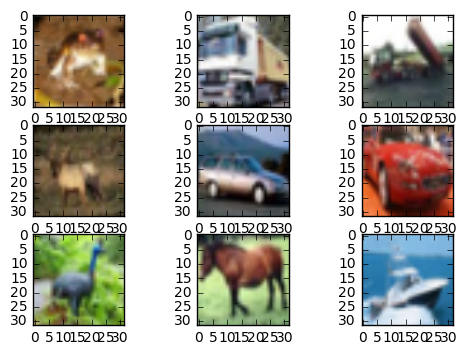

image shape:  (32, 32, 3)
50000 training samples
10000 test samples
10 classes


In [4]:
# Visualize sample images

# Plot ad hoc CIFAR10 instances
from keras.datasets import cifar10
from matplotlib import pyplot
from scipy.misc import toimage
import numpy as np
# load data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
# create a grid of 3x3 images
for i in range(0, 9):
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(toimage(X_train[i]))
# show the plot
pyplot.show()

nb_classes = np.sum(np.unique(y_train).shape)

print('image shape: ', X_train.shape[1:])
print(X_train.shape[0], 'training samples')
print(X_test.shape[0], 'test samples')
print(nb_classes, 'classes')

In [2]:
# Simple Convolutional Neural Networks

import theano
# theano.config.blas.ldflags = "-LC:\\openblas -lopenblas"
# print(theano.config.blas.ldflags)

#I have to set optimizer configuration to be Nonel otherwise, there will be error 
#'AbstractConv2d Theano optimization failed: there is no implementation available supporting the requested options'
# Even though in this way the speed will be much slower.
theano.config.optimizer = 'None'
# print(theano.config.optimizer)

import numpy
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# load data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# normalize inputs from 0-255 to 0.0-1.0
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

# Create the model
model = Sequential()
model.add(Convolution2D(32, 3, 3, input_shape=(3, 32, 32), border_mode='same', activation='relu', W_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Convolution2D(32, 3, 3, activation='relu', border_mode='same', W_constraint=maxnorm(3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu', W_constraint=maxnorm(3)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
# Compile model
epochs = 25
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
print(model.summary())


# Fit the model
model.fit(X_train, y_train, validation_split = 0.1, nb_epoch=epochs, batch_size=20)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_3 (Convolution2D)  (None, 32, 32, 32)    896         convolution2d_input_2[0][0]      
____________________________________________________________________________________________________
dropout_3 (Dropout)              (None, 32, 32, 32)    0           convolution2d_3[0][0]            
____________________________________________________________________________________________________
convolution2d_4 (Convolution2D)  (None, 32, 32, 32)    9248        dropout_3[0][0]                  
____________________________________________________________________________________________________
maxpooling2d_2 (MaxPooling2D)    (None, 32, 16, 16)    0           convolution2d_4[0][0]            
___________________________________________________________________________________________

In [ ]:
# Deeper Convolutional Neural Networks
import theano
theano.config.optimizer = 'None'

import numpy
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# load data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# normalize inputs from 0-255 to 0.0-1.0
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

# Create the model
model = Sequential()
model.add(Convolution2D(32, 3, 3, input_shape=(3, 32, 32), activation='relu', border_mode='same'))
model.add(Dropout(0.3))
model.add(Convolution2D(32, 3, 3, activation='relu', border_mode='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(64, 3, 3, activation='relu', border_mode='same'))
model.add(Dropout(0.25))
model.add(Convolution2D(64, 3, 3, activation='relu', border_mode='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(128, 3, 3, activation='relu', border_mode='same'))
model.add(Dropout(0.25))
model.add(Convolution2D(128, 3, 3, activation='relu', border_mode='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(1024, activation='relu', W_constraint=maxnorm(3)))
model.add(Dropout(0.4))
model.add(Dense(512, activation='relu', W_constraint=maxnorm(3)))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))

# Compile model
epochs = 15
lrate = 0.001
decay = 1e-7
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
print(model.summary())

# Boolean, whether to use data augmentation
data_augmentation = True
from keras.preprocessing.image import ImageDataGenerator

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(X_train, y_train,
              batch_size=64,
              nb_epoch=epochs,
              validation_split = 0.1)
else:
    print('Using real-time data augmentation.')
    # Do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(X_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(X_train, y_train,
                        batch_size=16),
                        samples_per_epoch=X_train.shape[0],
                        validation_data=(X_test, y_test),
                        nb_epoch=epochs)

# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
Using Theano backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 32, 32, 32)    896         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 32, 32, 32)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 32, 32, 32)    9248        dropout_1[0][0]                  
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 32, 16, 16)    0           convolution2d_2[0][0]            
___________________________________________________________________________________________

## Your description
with the following main parts:

<dl>

<dt>Introduction</dt>
<dd>
At a high-level, what are the approaches you considered and why?
</dd>

<dt>Method</dt>
<dd>
Describe your entire pipeline, such as data-preprocessing, model selection, and hyper-parameter optimization.
</dd>

<dt>Results</dt>
<dd>
Describe the experimental process you took to arrive at the solution.
For example:
(1) compare your approach against other approach(es) you have tried, as
well as the MLP baseline classifer.
(2) compare against different settings of model parameters, e.g. regularization type/strength, number of hidden units or structure of a neural network, types of kernel in a SVM, etc. 

<dt>Conclusion</dt>
<dd>
Summarize what you have learned from the experiments and discuss the limitations and potential future improvements of your current method.
</dd>

<dt>References</dt>
<dd>
Cite any publically available code, blog posts, research papers, etc. you used or got ideas from.
</dl>

## Description

#### Introduction
Recognizing objects in photographs is a difficult and complicated problem and thus basic classifiers (eg, SVM, KNN etc) or even tradition neural networks tend to have a poor performance towards this. The sample code for MLP only has accuracy around 43%, which is far from satisfactory. To tackle the difficulty, I try to use Convolutional Neural Networks (CNN). As discussed in Chapter12 on Page381 of Python Machine Learning textbook, CNN has extraordinary good performance on image classification by building layers of feature detectors to take the spatial arrangement of pixels in an input image into account.

#### Method
Data preprocessing: 
Same procedures as in the sample code. Load the data for training and testing respectively, cast data to floating point values, normalize X values(from pixel value range 0-255 to 0.0-1.1) and transfor labels Y into one hot encoding format.

Model:
I first try a simple CNN model to get an intuitive idea of whether CNN can actually improve the performance. The model adds two 3x3 convolutional layers and one 2x2 pooling layer before the standard MLP. Then I try a more complicated model by adding repeated stacks of convolutional layer(feature maps), dropout and pooling layer. I add the option of realtime data augmentation as well.

Hyper-parameter:
Due to the complexity of the model as well as the long running time, for the parameters of each layer as well as parameters for SGD, I don't tune and optimize them, just select some common values. I choose batch-size to be 16 or 64 and epoch number to be 5 and 25.

#### Results
With the accuracy result of MLP given, I believe that other basic classifiers won't have a better performance than it. So I searched some online references and conduct experiments by using CNN directly. Because my computer is not powerful and the process is quite slow, I can only try some options on parameters. For batch size 64, after 5 epochs, the accuracy is close to 60%. It seems that rectifier activation function tends to perform better than tanh. Eventually for the simple CNN, I use batch size 16 and after 25 epochs, the accuracy is close to 70%. Unfortunately, I don't have enough time and my computer is too slow to fully run the second CNN model. The code has no error indeed, just need time and computational power to run, and if everything goes well, the accuracy should be more than 80% shown by the results from the first reference website listed below.

#### Conclusion
As shown by many other experiments, the CIFAR-10 problem is best solved using a Convolutional Neural Networks (CNN) and CNN gives high accuracy (sometimes even more than 90% if the model is deep and well-tuned enough). I gain a basic understanding of CNN after doing the experiments, spotting the outcomes during each epoch and reading some references. 

One limitation not only for CNN but also basic MLP is that the running time is much longer than other basic classifiers at least on my computer. Another limitation is that I don't tune the hyper-parameters and it maybe tiring to use GridSearchCB=V or other search methods to get the best hyper-parameters because each layer can have different hyper-parameters and there are quite a lot of candidates to train and validate. 

For the improvement, possibly the code can be run on a virtual machine or other platforms to increase the speed. If time allows, I can train the model for even more epochs to improve performance (Actually many other similar experiments use more than 200 epochs). Another improvement option can be using some data augmentation by methods such as horizontal image flips (I add this option in the second model above, but unfortunately I haven't tested whether it really improves the performance and to what extent is makes the accuracy better. Also, we can always design even larger CNN, but of course, the larger the network, the higher the complexity and design difficulty.

#### References
The design of good Convolutional Neural Networks model for recognition is not that easy. So I basically follow the tutorial with discussion, explanation and code on this website: http://machinelearningmastery.com/object-recognition-convolutional-neural-networks-keras-deep-learning-library/
Also, the sample code on GitHub for data augmentation: https://github.com/fchollet/keras/blob/master/examples/cifar10_cnn.py